<a href="https://colab.research.google.com/github/Nelci/-CF-III-Implementacao-do-Sistema-Deploy-cultura-DevOps/blob/main/LDA_funk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import pandas as pd
import numpy as np
import spacy

import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint


In [3]:
# for plotting purpouse
!pip install data-science-utils

from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

In [4]:
!python -m spacy download pt_core_news_sm #pacote de protugues do spacy

2023-07-23 20:26:29.260356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 70.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [5]:
path =  '/content/drive/MyDrive/UFRGS/mestrado/PLN/analise funk/analise_musicas - refrao'
df = pd.read_csv(path+'//base_refrao.csv',
                sep = ';',decimal=',')

df2 = df.groupby(['musica']).agg({'refrao':'sum'}).reset_index()
# Convert to list
data = df2.refrao.values.tolist()

FileNotFoundError: ignored

In [ ]:

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['yeah', 'obrigado', 'deus', 'me', 'deu', 'um', 'trabalho', 'to', 'no', 'corre', 'na', 'luta', 'pra', 'vencer', 'sei', 'que', 'tempo', 'nao', 'volta', 'pro', 'passado', 'passado', 'vem', 'me', 'transparecer', 'meu', 'presente', 'junta', 'com', 'futuro', 'quem', 'nao', 'botou', 'fe', 'pagou', 'pra', 'ver', 'eu', 'descarrego', 'pente', 'palavras', 'pro', 'mundo', 'um', 'milhao', 'de', 'sonho', 'pra', 'escrever']]


In [ ]:
nlp = spacy.load('pt_core_news_sm', disable=['parser', 'ner'])  #estou carregando um modelo de stamming para filtrar as musicas só por advervios, verbos, sustantivos e adjetivos

In [ ]:
aux = nlp(" ".join(data_words[1]))
for token in aux:
    print(token.text, token.pos_, token.lemma_)

respeita VERB respeitar
corre VERB correr
que SCONJ que
nos PRON nós
fez VERB fazer
deixa NOUN deixa
de ADP de
lado NOUN lado
mau ADJ mau
olhado NOUN olhado
calma ADJ calmo
que PRON que
vai AUX ir
chegar VERB chegar
sua DET seu
vez NOUN vez
muita DET muito
labuta NOUN labuta
ooh AUX ooh
foi AUX ser
muita DET muito
luta NOUN luta
ooh DET ooh
pra SCONJ pra
poder VERB poder
chegar VERB chegar
pe ADP pe
no ADP em o
chao NOUN chao
alma NOUN almar
pura ADJ puro
deus VERB deus
me PRON eu
abencoe VERB abencoe
me PRON eu
livre ADJ livre
dos ADP de o
males NOUN mal
dessa ADP de esse
vida NOUN vida
louca ADJ louco
longe ADV longe
de ADP de
maldade NOUN maldade


In [ ]:

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [ ]:

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN','ADJ','VERB','ADV'])
len(data_lemmatized)

596

In [ ]:
data_lemmatized

['Yeah obrigar Deus dar trabalho to correr luta vencer saber tempo volta passar passado vir transparecer presente junta futuro botar pagar ver descarrego pente palavra mundo milhao sonho escrever',
 'respeitar correr fazer deixa lado mau olhado calmo chegar vez labuta luta poder chegar chao almar puro deus abencoe livre mal vida louco longe maldade',
 'perfume ficar ainda sinto aroma cobertor esqueco menos cheiro saudade dar desespero dever proibir usar perfume lembrar maluco fazer ninguem mais fazer filha puta querer mais baguncar vida mal curar vira recair logo tar tao bem resolver hoje ter jeito recair culpa culpa',
 'trintar minuto ter graca gata damar perder mundo saber tempo ter mais graca gata achar lindar absurdo princesa hoje mais amanho saber saber pro resto vida so vez trintar minuto ter graca gata trintar minuto ter graca nao trintar minuto ter graca gata trintar minuto ter graca nao',
 'musica pro clima ficar diferente relaxar trazer mary jane money ficar ricoso mujer quer

In [ ]:

# create the document-word matrix

vectorizer = CountVectorizer(analyzer='word',
                             min_df=2, #minima recorrencia de 1 palavra
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',
   )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

vectorizer.get_feature_names_out()

array(['abalar', 'abandonar', 'abandono', ..., 'xota', 'yeah', 'zona'],
      dtype=object)

In [ ]:
data_vectorized

<596x1609 sparse matrix of type '<class 'numpy.int64'>'
	with 11329 stored elements in Compressed Sparse Row format>

In [ ]:

# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=5,               # Number of topics
                                      max_iter=20,
# Max learning iterations
                                      learning_method='batch',
                                      random_state=100,
                                      evaluate_every = -1

                )

In [ ]:

lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

LatentDirichletAllocation(max_iter=20, n_components=5, random_state=100)
Log Likelihood:  -112343.3121350933
Perplexity:  815.5490494443528


In [ ]:

# Create Document — Topic Matrix
# lda_output = best_lda_model.transform(data_vectorized)
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(lda_model.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [ ]:
lda_output

array([[0.0733726 , 0.0081467 , 0.00805763, 0.51403286, 0.39639021],
       [0.00843932, 0.00866015, 0.00848829, 0.00845651, 0.96595573],
       [0.23286709, 0.00510809, 0.00502791, 0.00508246, 0.75191446],
       ...,
       [0.00971783, 0.00977128, 0.0098525 , 0.96071878, 0.00993961],
       [0.01454197, 0.01449807, 0.14124316, 0.01444999, 0.81526682],
       [0.00721943, 0.00727836, 0.00729693, 0.007221  , 0.97098428]])

In [ ]:
df_output = pd.DataFrame(data = lda_output,columns=topicnames)
df_output.sum(1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
591    1.0
592    1.0
593    1.0
594    1.0
595    1.0
Length: 596, dtype: float64

In [ ]:
# PCA na tabela de frequencia de palavras

pca = PCA(n_components=100)
matriz_pca = pca.fit_transform(data_vectorized.toarray())
# print(matriz_pca)
pd.DataFrame(data=pca.explained_variance_ratio_).to_excel(r'/content/drive/MyDrive/UFRGS/mestrado/PLN/analise funk/analise_musicas LDA/pca.xlsx')


# não funciona, pouca variância explicada, primeiras 2 componentes só explicam 11% da variância

In [ ]:
df_final = pd.concat([df2,df_output],axis=1)
df_final.head()
df_final.to_excel(r'/content/drive/MyDrive/UFRGS/mestrado/PLN/analise funk/analise_musicas LDA/musicas_cluster.xlsx')


In [ ]:
df_final['cluster'] = df_final[['Topic0','Topic1','Topic2','Topic3','Topic4']].idxmax(1)
df_final['cluster_value'] = df_final[['Topic0','Topic1','Topic2','Topic0','Topic0']].max(1)
df_final['cluster_distance'] = 1-df_final['cluster_value']

<Axes: title={'center': 'Cardinalidade'}>

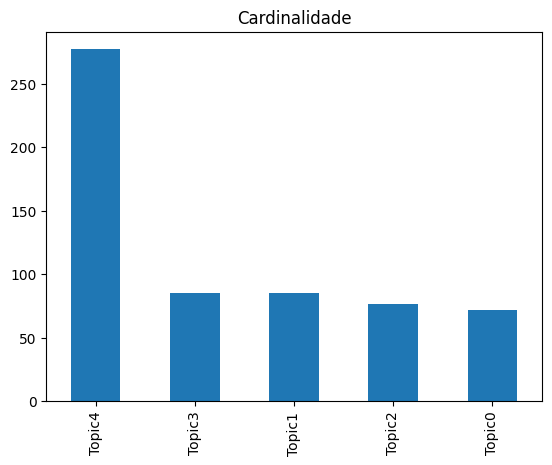

In [ ]:

cardinalidade = df_final['cluster'].value_counts()
cardinalidade.plot(kind='bar',title='Cardinalidade')

<Axes: title={'center': 'Magnitude'}, xlabel='cluster'>

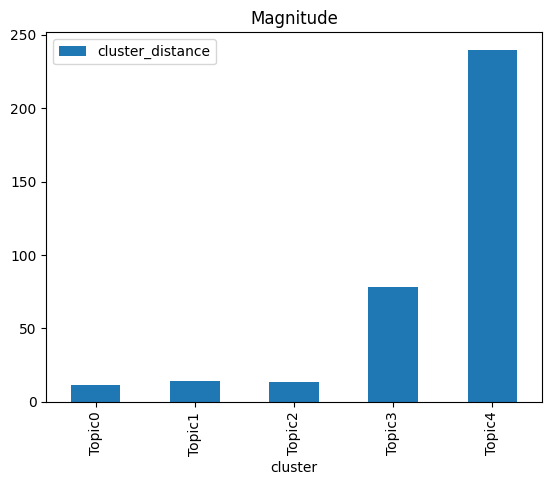

In [ ]:
# magnitude

df_final['aux'] = 1

magnitude = df_final.groupby(['cluster']).agg({'cluster_distance':'sum','aux':'sum'})

magnitude[['cluster_distance']].plot(kind='bar',title='Magnitude')

<Axes: title={'center': 'Magnitude percentual'}, xlabel='cluster'>

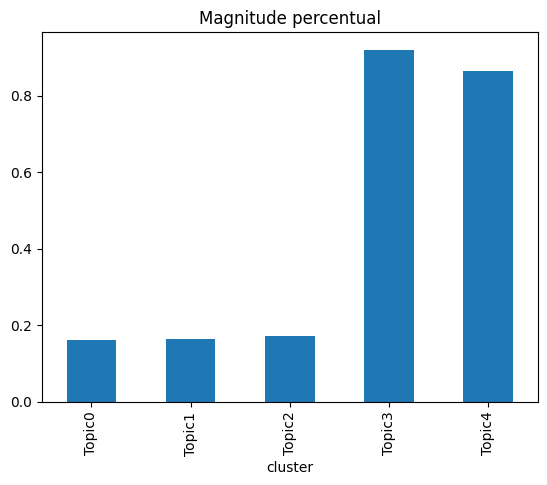

In [ ]:
magnitude['magnitude_percentual'] = magnitude['cluster_distance']/magnitude['aux']

magnitude['magnitude_percentual'].plot(kind='bar',title='Magnitude percentual')

In [ ]:
magnitude

,cluster_distance
cluster,
Topic0,11.572285
Topic1,13.898285
Topic2,13.257576
Topic3,78.179208
Topic4,239.630563


<Axes: xlabel='cardinalidade', ylabel='magnitude'>

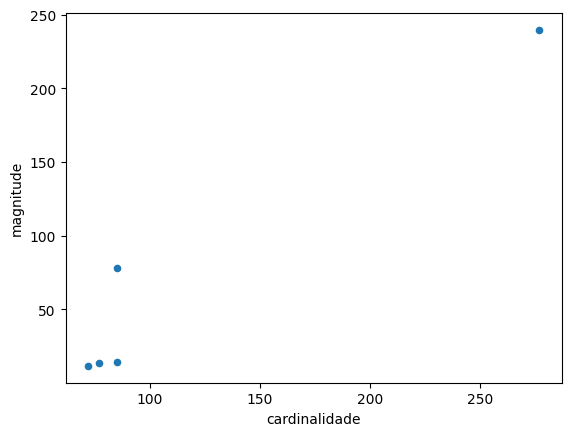

In [ ]:
cardvsmg = magnitude.copy()
cardvsmg['cardinalidade'] = cardinalidade
cardvsmg['magnitude'] = cardvsmg['cluster_distance']

cardvsmg.plot(x = 'cardinalidade', y = 'magnitude', kind='scatter')

In [ ]:
cardvsmg[['cardinalidade','magnitude']]

,cardinalidade,magnitude
cluster,,
Topic0,72,11.572285
Topic1,85,13.898285
Topic2,77,13.257576
Topic3,85,78.179208
Topic4,277,239.630563


In [ ]:

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
df_topic_keywords.index = topicnames
# View

In [ ]:
print(df_topic_keywords)

          abalar  abandonar  abandono   abencoar   abracar    abraco  \
Topic0  0.200003   0.200005  0.200002   0.203051  0.206534  0.202930   
Topic1  2.827519   0.201928  2.199994   0.201747  0.200006  4.255088   
Topic2  0.200003   0.200282  0.200002   0.200471  0.200006  2.199697   
Topic3  0.205356   0.200916  0.200002   1.640815  0.200571  2.482058   
Topic4  1.567120  12.196869  0.200001  11.753916  5.192883  2.860227   

           abrir   absurdo    abusar     acabar  ...       voz     vulgo  \
Topic0  3.404456  0.200004  3.206044   0.200445  ...  0.200005  0.200004   
Topic1  2.514475  2.200764  0.200009   9.736654  ...  0.206115  0.200004   
Topic2  0.201437  0.200004  0.200009   5.073781  ...  0.200005  1.199991   
Topic3  0.201515  0.200004  0.200009   0.200456  ...  0.204101  0.200004   
Topic4  7.678117  1.199225  2.193929  12.788663  ...  6.189774  7.199997   

          whisky    xereca    xereco     xinga    xingar      xota      yeah  \
Topic0  8.201681  0.202921  1.

In [ ]:

df_topic_keywords.to_csv(r'/content/drive/MyDrive/UFRGS/mestrado/PLN/analise funk/analise_musicas LDA/topicos.csv',
                         sep=';',decimal=',',index=False)



In [ ]:
df_topic_keywords.sum(1)

Topic0    2576.534790
Topic1    2794.035671
Topic2    2736.570956
Topic3    2857.769707
Topic4    7402.088876
dtype: float64